# **Tutorial 4: Return Levels Using Normal and GEV Distributions**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

Now that we have learned how to create a PDF for the GEV distribution, we can utilize it to calculate return values based on this distribution.

Return levels are computed from a PDF using the cumulative distribution function (CDF), which provides the probability that a randomly drawn variable from our distribution will be less than a certain value X (for our specific variable). In the case of extreme events, rare values have a higher probability since most random draws tend to be smaller, such as in the case of small storms. For example, if there is a 99% chance of observing a storm with 80mm of rainfall or higher, it means that there is a 1% chance of observing a storm with at least 80mm of rainfall. This implies that the 100-year storm would bring 80mm of rain. In simple terms, the return level is the inverse of the CDF.

To compute return levels, you can use the function estimate_return_level_from_params(x, location, scale, shape). In this case, x represents the probability of a random value from our distribution being lower. For example, for the 100-year storm, x would be 0.99, and for the 1000-year storm, it would be 0.999.

By the end of this tutorial, you will be able to:

- Estimate return levels using a given quantile and the parameters of a GEV distribution.
- Compare return level plots for GEV and normal distributions.

# **Setup**

In [1]:
# google colab installs 

# !pip install -q condacolab
# import condacolab
# condacolab.install()

# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install cartopy
# !pip install scipy


In [2]:
# imports 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pooch

from scipy import stats
from scipy.stats import genextreme as gev

In [3]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [4]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# **Section 1: Return Levels and Return Periods**

In [5]:
# download file: 'precipitationGermany_1920-2022.csv'
url_precipitationGermany = "https://osf.io/xs7h6/download"


data = pd.read_csv(pooch.retrieve(url_precipitationGermany, known_hash=None),
                   index_col=0).set_index('years')
data.columns=['precipitation']
precipitation = data.precipitation

In [6]:
shape, loc, scale = gev.fit(precipitation.values,0)

This utility function takes a given *quantile* and the GEV parameters (loc, scale, shape) and computes the corresponding return level

In [7]:
def estimate_return_level(quantile,loc,scale,shape):
    level = loc + scale / shape * (1 - (-np.log(quantile))**(shape))
    return level

Now, let's utilize this function to calculate the 2-year level, which represents the precipitation level we anticipate with a 50% chance in each year. The function requires the quantile value 'x' and three parameters related to GEV (Generalized Extreme Value) distribution: location, scale, and shape. The function will provide the return level corresponding to the given quantile.
For instance, the 90th quantile (x=0.9) would yield the precipitation value expected once every 10 years (with a 10% chance of observing it each year).

In [8]:
estimate_return_level(0.5,loc,scale,shape)

29.07803009997505

This function is implemented as part of the scipy GEV implementation - here called the "Percent point function" or ppf:

In [9]:
gev.ppf(0.5,shape,loc=loc,scale=scale)

29.07803009997506

It is probably easier to replace x with a variable called “rp” (= return period). You can use the formula 1-(1/return period)
to compute rp. So a 100-year storm would be 1-(1/100) = 0.99. Compute the 100- and 1000-year storm. 

In [10]:
estimate_return_level(1-1/100,loc,scale,shape)

64.20998052543192

In [11]:
estimate_return_level(1-1/1000,loc,scale,shape)

86.51985389906702

Now we will make a figure in which we plot return-levels against return-periods:
1. Create vector “periods” which is a sequence of 2 to a 1000-years (in two steps).
2. Create a vector “levels” which is the associated return-levels for those return periods.
3. Plot the return levels against the return periods. Typically, the return periods go on the x-axis at a log-scale.


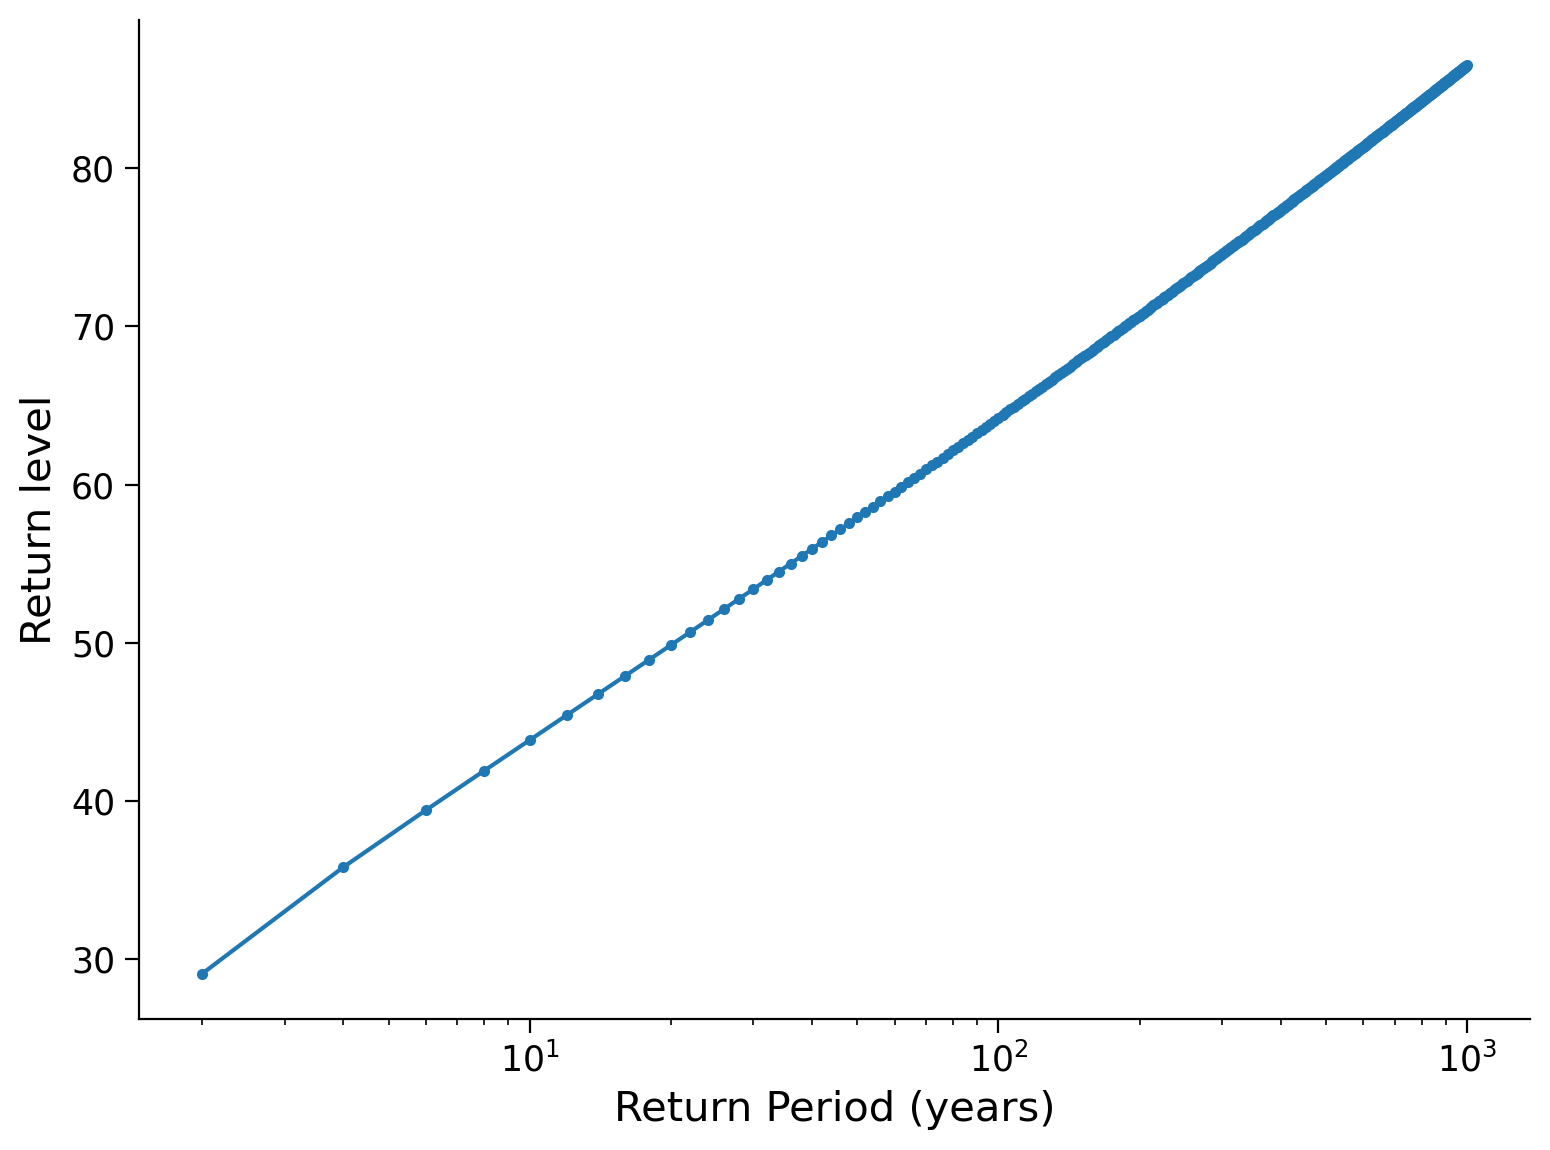

In [12]:
periods = np.arange(2,1000,2)
quantiles = 1-1/periods
levels = estimate_return_level(quantiles,loc,scale,shape)

fig,ax=plt.subplots()
ax.plot(periods,levels,'.-')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Return level')
ax.set_xscale('log')


It would be interesting to compare the return levels from a normal and GEV distribution. Compute the 
50-,100-,500- and 1000-year based on a normal distribution and based on the GEV distribution
like above. 

You can use the `stats.norm.ppf` and `stats.genextreme.ppf` functions: The "Percent point function" (ppf) is the inverse of the CDF function: It takes the quantiles (and the distribution parameters) and returns the values. 
For the normal distribution, the mean and standard deviation are required inputs. 
For the GEV distribution, the shape, location, and scale parameters are necessary. It's important to note that there are two sign conventions for the shape parameter. In this case, you will need to multiply the shape obtained from the fit above by -1.

In [13]:
years = np.array([50,100,500,1000])
quantiles = 1-1/years

df = pd.DataFrame(index=years)
df['Normal Distribution'] = stats.norm.ppf(quantiles,loc=precipitation.mean(), scale=precipitation.std())
df['GEV'] = gev.ppf(quantiles,shape,loc=loc,scale=scale)

In [14]:
df

,Normal Distribution,GEV
50,51.359942,57.922728
100,54.066103,64.209981
500,59.544102,79.555379
1000,61.649382,86.519854


## **Coding Exercise 1**

Plot and compare return levels for Normal and GEV distributions.
Create a return time plot that plots
1. the empirical return level
2. the estimate based on a normal distribution
3. the estimate based on a GEV distribution

Question: What can you say about the plot and how the distributions describe the data? How do the distributions differ? At short/long return periods? What will happen at even longer return periods?

*Note that the empirical return level is contained in the "return_level_obs" variable of the "fit" dataset:*

In [15]:
# fit.return_level_obs
# ohad comment: I have no idea what fit is, nor return_level_obs. I believe we should delete this, but we need to change the text above as well.


In [16]:
def empirical_return_level(data):
    '''
    Compute empirical return level using the algorithm introduced in Tutorial 2
    '''
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df['sorted'] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df['ranks_sp'] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df['exceedance'] = df['ranks_sp']/(n+1)
    # find return period
    df['period'] = 1 / df['exceedance']

    df = df[::-1]

    out = xr.DataArray(
        dims=['period'],
        coords={'period':df['period']},
        data=df['sorted'],name='level')
    return out

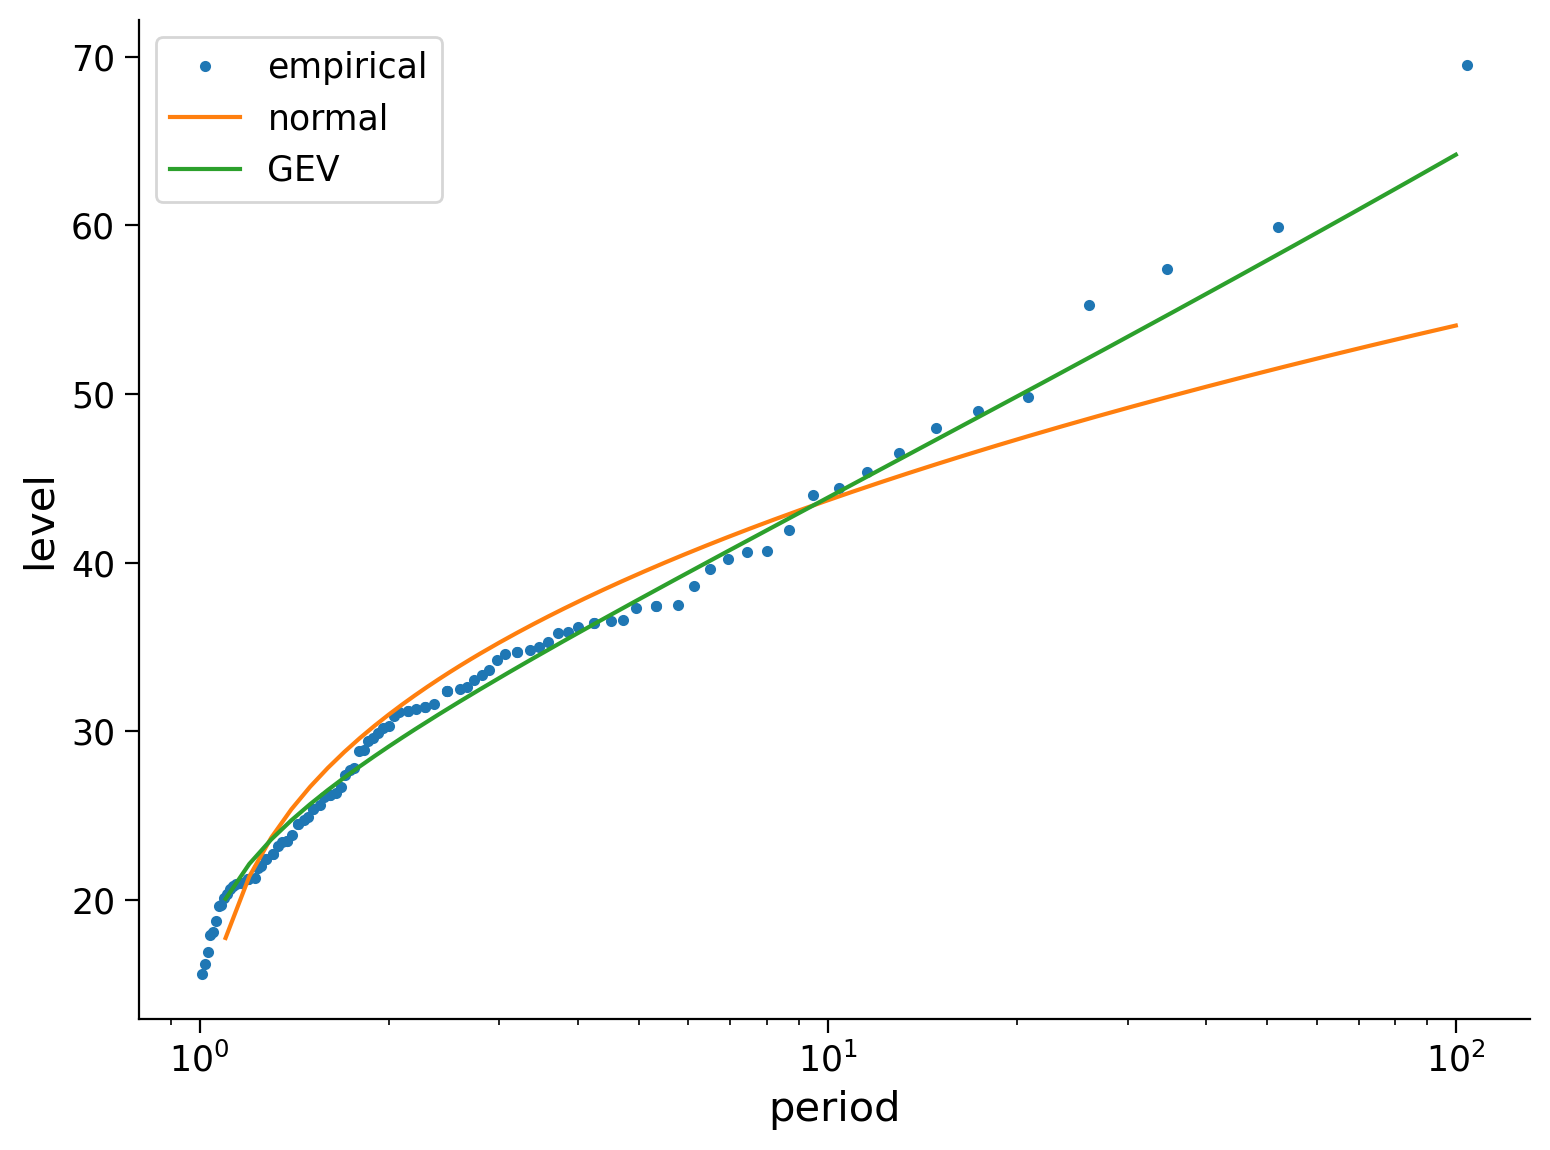

In [17]:
# to_remove solution
fig,ax=plt.subplots()
empirical_return_level(precipitation).plot(ax=ax,marker='.', linestyle='None')
years = np.arange(1.1,100,0.1)
ax.plot(years,stats.norm.ppf(1-1/years,loc=precipitation.mean(), scale=precipitation.std()))
ax.plot(years,gev.ppf(1-1/years,shape,loc=loc,scale=scale))

ax.set_xscale('log')

ax.legend(['empirical','normal','GEV'])

In [18]:
# to_remove explanation
"""
Put your observations here. GEV distribution describes the data better than the normal distribution. However, they are similar for shorter return periods. This suggests that for common, less extreme events (short return periods), both the Normal and GEV distributions provide a similar representation of the data. This similarity is likely due to the fact that for less extreme events, the tail of the distribution (which captures extreme events) is less relevant. When we move toards longer return periods (which correspond to more extreme events), the two curves start to diverge.
""";

## **Bonus: Implement your own bootstrapping algorithm**

Above, we used `gev.ppf` to compute return levels for the parameters that we had previously fitted using ` to fit the GEV distribution to the data, calculate confidence intervals, and perform similar tasks. To gain a deeper understanding, you may find it beneficial to attempt implementing such an algorithm from scratch. One possible approach could involve the following steps:

1. Begin with the `gev` function which can be employed to fit GEV parameters using `gev.fit(data)`. This function returns the three parameters, taking note of a sign change in the shape parameter (as different conventions exist).
2. Determine the number of observations in the data, denoted as N.
3. Perform resampling by randomly drawing N samples from the data with replacement. This process generates an artificial ensemble that differs from the true data due to resampling.
4. Estimate the parameters for each resampling.
5. Utilize the `gev.ppf` function for each parameter set to compute the return level.
6. Visualize the resulting uncertainty bands by plotting multiple lines or calculating confidence intervals using `np.quantile`.


# ohad comment: I don't understand this question at all. despite the lengthy instructions. why does the solution fake a random dataset from the original dataset? then does everything again? what does it teach the students? it works, but I haven't fixed anything because I don't get it

In [19]:
# to_remove solution

params = []
for i in range(1000):
    params.append(gev.fit(np.random.choice(precipitation,size=precipitation.size,replace=True)))

In [20]:
print('Mean estimate and 95% confidence intervals')
[
    np.mean(np.array(params),axis=0),
    np.quantile(np.array(params),[0.025,0.975],axis=0)
]

Mean estimate and 95% confidence intervals


[array([-0.04483848, 26.37825957,  7.3066938 ]),
 array([[-0.1998969 , 24.65353189,  6.22828455],
        [ 0.10165502, 28.15133007,  8.40355413]])]

In [21]:
years = np.arange(1.1,1000,0.1)
levels = []
for i in range(1000):
    levels.append(gev.ppf(1-1/years,*params[i]))
levels = np.array(levels)

Text(0, 0.5, 'return level (mm/day)')

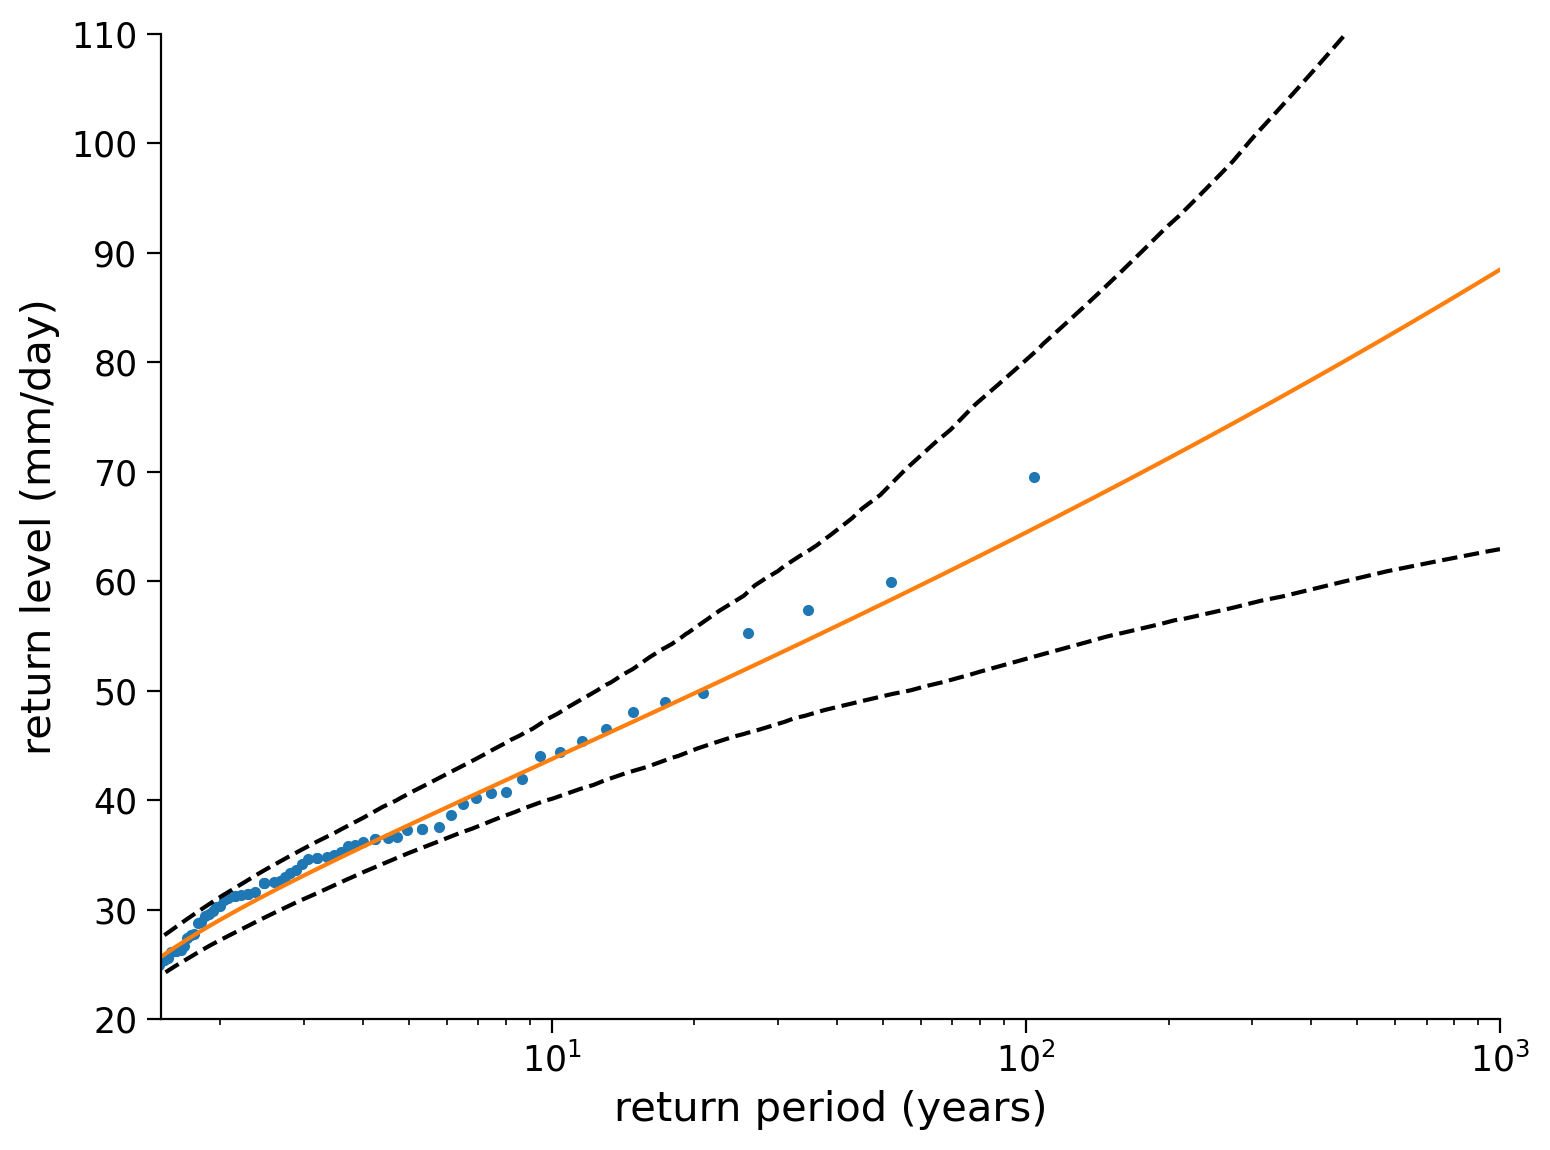

In [22]:
fig,ax=plt.subplots()
empirical_return_level(precipitation).plot(ax=ax,marker='.', linestyle='None')
ax.plot(years,levels.mean(axis=0))
ax.plot(years,np.quantile(levels,[0.025,0.975],axis=0).T,'k--')
ax.set_xlim(1.5,1000)
ax.set_ylim(20,110)
ax.set_xscale('log')
ax.set_xlabel('return period (years)')
ax.set_ylabel('return level (mm/day)')

# **Summary**
In this tutorial, we learned how to calculate return values based on the Generalized Extreme Value (GEV) distribution. We first understood the concept of return levels and how they are derived from the Probability Density Function (PDF) via the cumulative distribution function (CDF). We then learned to compute these return levels using given quantile and GEV parameters and how to create a figure to plot return-levels against return-periods using a log-scale on the x-axis. Finally, we compared the return levels derived from normal and GEV distributions using the "Percent point function" (ppf), leading to observations about how the distributions describe the data and differ at short/long return periods.